In [1]:
import numpy as np
import nibabel as nib
from nilearn import image
import os
import glob
from scipy import ndimage
from tqdm import trange

In [2]:
from scipy import ndimage

In [3]:
import random

# Folder Structure Before Processing

Download the image zips created for HAW Landshut(s3://deepc-landshut-data/). Unzip the images on the Dataset/ folder

```
Dataset
│   
│
└───MSSEG2/timestamp2
│   │
│   └───segs
│   |   │   
│   |   └───anatomy_seg
│   |   └───matter_seg
│   |   │ 
│   |   │    gt_013.nii.gz
│   |   │    ...
│   |
│   |   013.nii.gz
│   |   ...
│   
│
└───NAMIC_DS/NAMIC
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   lupus001.nii.gz
│   |   │    ...
│   |
│   |   lupus001.nii.gz
│   |   ...
│   
│
└───OpenMSData/crossectional
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   patient01.nii.gz
│   |   │    ...
│   |
│   |   patient01.nii.gz
│   |   ...
│   
│
└───OpenMSData/longitudnal
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   patient01.nii.gz
│   |   │    ...
│   |
│   |   patient01.nii.gz
│   |   ...
```

In [4]:
# NAMIC (256, 256, 256)
# MSSEG2 (356, 256, 256)
# Process OpenMSData cross (192, 512, 512)


In [17]:
def resize_store(img_list, seg_list, name, new_shape=(256,256,256)):
    
   
    os.makedirs(name, exist_ok=True)
    out_img_path = os.path.join(name, "Images")
    out_seg_path = os.path.join(name, "segments")
    os.makedirs(out_img_path, exist_ok=True)
    os.makedirs(out_seg_path, exist_ok=True)

    
    for i in trange(len(img_list)):
        img = nib.load(img_list[i]).get_fdata()
        img_name = img_list[i].split('/')[-1]
        seg = nib.load(seg_list[i]).get_fdata()
        
        
        
        if 'lupus' in img_name:
            img = img.transpose(0, 2, 1)
            seg = seg.transpose(0, 2, 1)
            seg /=seg.max()
            
        elif 'patient' in img_name:
            img = ndimage.rotate(img.transpose(  0,2, 1), 90,axes=(1, 2))
            seg = ndimage.rotate(seg.transpose(  0,2, 1), 90,axes=(1, 2), order=0)
            
        old_shape = seg.shape
        zoom = np.array([new_shape[i]/old_shape[i]for i in range(3)])
        
        resample_img =  nib.Nifti1Image(ndimage.zoom(img, zoom, mode='nearest'), np.eye(4))
        resample_seg = nib.Nifti1Image(ndimage.zoom(seg, zoom,  order=0, mode='nearest'), np.eye(4))
        
        nib.save(resample_img, os.path.join(out_img_path, img_name))
        nib.save(resample_seg, os.path.join(out_seg_path, 'seg_'+img_name))
    

In [18]:
def run_preprocess(og_files, seg_files):
    train = 0.7
    val = 0.2
    test = 0.1
    random.seed(108)
    list_len = len(og_files)
    assert len(seg_files) == list_len

    idx_list = [i for i in range(list_len)]
    random.shuffle(idx_list)

    train_idx= int(train*(len(idx_list)))
    val_idx = int(train_idx + val*(len(idx_list)))

    tr_img_list = [og_files[idx] for idx in idx_list[0:train_idx] ]
    tr_seg_list = [seg_files[idx] for idx in idx_list[0:train_idx] ]

    val_img_list = [og_files[idx] for idx in idx_list[train_idx:val_idx ]]
    val_seg_list = [seg_files[idx] for idx in idx_list[train_idx:val_idx ]]

    tst_img_list = [og_files[idx] for idx in idx_list[val_idx :]]
    tst_seg_list = [seg_files[idx] for idx in idx_list[val_idx :]]
    
    resize_store(tr_img_list, tr_seg_list, 'Train', new_shape=(256,256,256))
    resize_store(val_img_list, val_seg_list, 'Test', new_shape=(256,256,256))
    resize_store(tst_img_list, tst_seg_list, 'FinalTest', new_shape=(256,256,256))
    

In [7]:
inp_path = "OpenMSData/longitudnal"
lesion_folder = "lesion_segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files_1 =[file for file in sorted(glob.glob(og_filepath)) if '_1.nii.gz' in file]
og_files_2 = [file for file in sorted(glob.glob(og_filepath)) if '_2.nii.gz' in file]
seg_files_1 = sorted(glob.glob(seg_filepath))

og_files = og_files_1 + og_files_2
seg_files = 2*seg_files_1 
run_preprocess(og_files, seg_files)

100%|██████████| 4/4 [01:05<00:00, 16.45s/it]


In [8]:
inp_path = "OpenMSData/crosssectional"
lesion_folder = "lesion_segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
seg_files = sorted(glob.glob(seg_filepath))
run_preprocess(og_files, seg_files)

100%|██████████| 3/3 [01:46<00:00, 35.34s/it]


In [19]:
inp_path = "NAMIC_DS/NAMIC"
lesion_folder = "lesion_segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
seg_files = sorted(glob.glob(seg_filepath))
run_preprocess(og_files, seg_files)

100%|██████████| 1/1 [00:14<00:00, 14.51s/it]


In [10]:
inp_path = "MSSEG2/timestamp2"
lesion_folder = "segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
seg_files = sorted(glob.glob(seg_filepath))
run_preprocess(og_files, seg_files)

100%|██████████| 4/4 [01:11<00:00, 17.75s/it]


# Folder Structure After Processing
```
Dataset
│
└───Test
│   │
│   └───segments
│   │    │   JPCLNXXX.png
│   │    │   ...
│   │ 
│   └───Images
│       │   JPCLNXXX.png
│       │   ...
│   
└───Train
│   │ 
│   └───segments
│   │    │   JPCLNXXX.png
│   │    │   ...
│   │ 
│   └───Images
│       │   JPCLNXXX.png
│       │   ...
│
└───FinalTest
│   │ 
│   └───segments
│   │    │   JPCLNXXX.png
│   │    │   ...
│   │ 
│   └───Images
│       │   JPCLNXXX.png
│       │   ...
│
│
└───MSSEG2/timestamp2
│   │
│   └───segs
│   |   │   
│   |   └───anatomy_seg
│   |   └───matter_seg
│   |   │ 
│   |   │    gt_013.nii.gz
│   |   │    ...
│   |
│   |   013.nii.gz
│   |   ...
│   
│
└───NAMIC_DS/NAMIC
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   lupus001.nii.gz
│   |   │    ...
│   |
│   |   lupus001.nii.gz
│   |   ...
│   
│
└───OpenMSData/crossectional
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   patient01.nii.gz
│   |   │    ...
│   |
│   |   patient01.nii.gz
│   |   ...
│   
│
└───OpenMSData/longitudnal
│   │
│   └───lesion_segs
│   |   │ 
│   |   │   patient01.nii.gz
│   |   │    ...
│   |
│   |   patient01.nii.gz
│   |   ...

```

In [11]:
import matplotlib.pyplot as plt


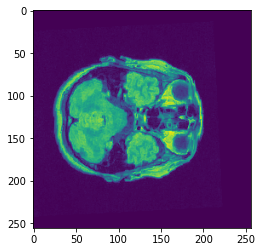

In [12]:
inp_path = "NAMIC_DS/NAMIC"
lesion_folder = "lesion_segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
plt.imshow(nib.load(og_files[0]).get_fdata().transpose(0, 2, 1)[...,100])

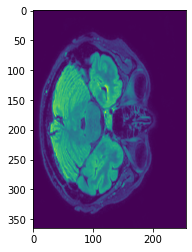

In [13]:
inp_path = "MSSEG2/timestamp2"
lesion_folder = "segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
plt.imshow(nib.load(og_files[0]).get_fdata()[...,100])

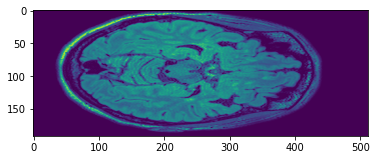

In [14]:
inp_path = "OpenMSData/crosssectional"
lesion_folder = "lesion_segs"

og_filepath = os.path.join(inp_path, '*.nii.gz')
seg_filepath = os.path.join(inp_path, lesion_folder,'*.nii.gz')

og_files = sorted(glob.glob(og_filepath))
plt.imshow(ndimage.rotate(nib.load(og_files[0]).get_fdata().transpose(  0,2, 1), 90,axes=(1, 2))[...,256])

In [15]:
nib.load(og_files[0]).get_fdata().shape

(192, 512, 512)

In [16]:

1, 2, 0
1, 0, 2
2, 1, 0
2, 0, 1

(2, 0, 1)